# 1st Assignment: Secondary structure prediction, influence of protein family and using evolutionary information.

This report contains a description of my work for the first assignment of the "Advanced Methods in Bioinformatics" course 2019/2020 given at the ULB/VUB by Matthieu Defrance and Wim Vranken. The assignment was to implement a secondary structure prediction algorithm, analyse the influence of the protein family and use evolutionary information. In this report all the cells must be ran in the given order since some code uses previously defined functions and imports.

## Table of contents
1. [Introduction](#introduction)
2. [Methods](#Methods)
    1. [Theory](#Theory)
        1. [GOR III](#GORIII) 
        2. [Neural Network and PHD method](#NN)
        3. [Protein class prediction](#CATH)
    2. [Implementation](#Implementation)
        1. [BLAST and CLUSTAL OMEGA](#BLAST)
        2. [GOR III](#GORIII_i) 
        3. [Neural Network and PHD method](#NN_i)
        4. [Protein class prediction](#CATH_i)
3. [Results and Discussion](#Results)
    1. [GOR III](#GORIII_res)
    2. [Neural Network](#NN_res)
    3. [CATH family](#CATH_res)
4. [Conclusion](#Conclusion)

## Introduction <a name="Introduction"></a>

The protein secondary structure is the three dimensional form of local segments of proteins. The most common structures are $\beta$-sheets and $\alpha$-helices. Several algorithms exist to predict locally the secondary structure of the protein without computing its global tertiary structure (three dimensional shape of the protein) however since distant interactions of residues have an effect on the secondary structure, these algorithms have a limited performance. The state of the art secondary structure algorithms that include evolutionary information have an average accuracy ($Q_3$ score) below 80\%.

Two classes of algorithms that are commonly used for secondary structure prediction are those based on statistics and those based on machine learning. In this assignment these two classes of algorithms are explored by implementing GOR III <cite data-cite="7413522/2YZQU6A6"></cite> which is based on information theory and a 1 hidden layer feed forward neural network. These algorithms were implemented on two provided data sets, one from STRIDE and the other one from DSSP. They contain the secondary structure that was experimentally obtained for 493 proteins.

Moreover the influence of adding evolutionary information to these algorithms is also explored. To do so, BLAST was run for (almost) all proteins and the homologous sequences were aligned using a multiple sequence alignment using a Python script. However due to time constraints, this was done for all but 9 proteins.

Finally, given the secondary structure prediction of a sequence, a classifier was trained to predict the CATH protein family of the sequence. 

In the next section the theory behind those algorithms as well as their implementation in python is provided. Then in the [Results and Discussion](#Results) section, their performance is presented and then analysed.
## Methods <a name="Methods"></a>

### Theory  <a name="Theory"></a>

#### GOR III  <a name="GORIII"></a>

The GOR methods are based on the concepts of pointwise mutual information (pmi) between random variables:
\begin{align}
I_{X,Y}(x;y) = \log \frac{p_{X,Y}(x,y)}{p_X(x)p_Y(y)}
\end{align}
where $I$ is the pointwise mutual information, $X$ and $Y$ are two discrete random variables, $x$ and $y$ are realisations of $X$ and $Y$ respectively and $p_X(x)$ and $p_Y(y)$ are the probability mass functions of $X$ and $Y$. The concept of difference of pmi between a realisation of a random variable and its complement is also used:
\begin{align}
I(\Delta x;y) = I(x;y) - I(\bar{x};y)
\end{align}
where $\bar{x}$ is the complement of $x$ in the sample space. $I(\Delta x;y)$ is a measure of how much y explains x. It can be easily checked that if $I(\Delta x,y) = 0$, $y$ does not provide any information on $x$ i.e. $p_{X,Y}(x,y) = p_X(x)p_Y(y)$. If $I(\Delta x;y) > 0$, $y$ explains better $x$ than $\bar{x}$ i.e. $p_{X|Y}(x|y)>p_{X}(x)$ and $p_{\bar{X}|Y}(\bar{x}|y)<p_{\bar{X}}(\bar{x})$. Similarly if $I(\Delta x;y) < 0$, $y$ explains better $\bar{x}$ than $x$ i.e. $p_{X|Y}(x|y)<p_{X}(x)$ and $p_{\bar{X}|Y}(\bar{x}|y)>p_{\bar{X}}(\bar{x})$. Changing the base of the log will only change the value of $I$ by a multiplicative constant, so any base can be chosen arbitrarily as long as it is consistent and the units are given (bits for base 2, nats for base $e$,...).

The GOR I method <cite data-cite="7413522/Y7JA53G9"></cite> estimates the pmi between a residue and the secondary structure adopted by that residue $I(SS,R)$ from a dataset. It estimates it as:
\begin{align}
\hat{I}(ss;r) = \log \frac{C_{SS,R}(ss,r)}{C_{SS}(ss)C_R(r)}
\end{align}
where $C_{SS,R}(ss,r)$ is the number of times residues $r$ have secondary structure $ss$ in the dataset. Similarly $C_{SS}(ss)$ is the number of residues taking the secondary structure $ss$ and $C_{R}(r)$ is the number of residues $r$ in the data set. Only  $\alpha$-helices and $\beta$-sheets are considered as individual secondary structures and all the other secondary structure are clustered as "other". Therefore the alphabet size of $SS$ is $|SS| = 3$. Only the 20 elementary amino acids are considered and the other ones are ignored or binned together into an "other" value so $|R| =20$ or $21$ depending on the implementation. 

Then the pmi of the complement of the secondary structure is estimated i.e.
\begin{align}
\hat{I}(\bar{ss};r) = \log \frac{\sum_{i \neq ss}C_{SS,R}(i,r)}{C_R(r)\sum_{i \neq ss}C_{SS}(i)}
\end{align}
Finally the difference between estimated pmis is computed:
\begin{align}
\hat{I}(\Delta ss;r) = \log \hat{I}(ss;r) - \hat{I}(\bar{ss};r)
\end{align}
This is equivalent to directly estimating it as:
\begin{align}
\hat{I}(\Delta ss;r) = \log \frac{C_{SS,R}(ss,r)}{\sum_{i \neq ss}C_{SS,R}(i,r)} -  \log \frac{C_{SS}(ss)}{\sum_{i \neq ss}C_{SS}(i)}
\end{align}

Once $\hat{I}(\Delta ss;r)$ for all the secondary structures $ss$ and for all the residues $r$ is computed, it can be used to predict the secondary structures of other proteins. The secondary structure of residue $r$ will be set to the secondary structure $ss$ with highest $\hat{I}(\Delta ss;r)$. 

GOR I has a limited performance since it does not take into account the influence of neighbouring residues on the secondary structure of a residue. 

GOR II to V also use information from the neighbouring residues of residue $k$ to predict the rescondary structure of residue $k$. If a window size of $2w+1$ is used, it would be desired to estimate $ I(\Delta ss_k;r_{k-w}, r_{k-w+1},...,r_{k},...,r_{k+w} )$ . However this cannot be directly estimated from the given datasets since it would require to estimate $|SS|\times |R|^{2w+1}$ parameters which is $480,000$ for $w=2$. While $I(\Delta ss_k;r_{k-w},...,r_{k+w})$ could be estimated using classical parametric or non parametric function approximations used in classical statistical inference, the GOR procedure approximates $I(ss_k;r_{k-w},...,r_{k+w})$ by simplifying its chain rule expansion by using independence assumptions.

In GOR III the following approximation is used:
\begin{align}
I(x;y_1,y_2,...,y_n) &= \sum_{j=1}^n I(x;y_j|y_1,...,y_{j-1}) \\
& \approx I(x;y_1) + \sum_{j=2}^n I(x;y_j|y_1) 
\end{align}
This assumes that when conditioned on $y_1$, conditioning on other $y_i$'s does not change the value of the pmi between $x$ and $y_1$.

For proteins this translates to 
\begin{align}
\hat{I}(\Delta ss_k;r_{k-w},...,r_{k+w}) \approx \hat{I}(\Delta ss_k;r_k) + \sum_{j=-w \\ j\neq 0}^w \hat{I}(\Delta ss_k;r_{k+j}|r_k) 
\end{align}
where  $\hat{I}(\Delta ss_k;r_k)$ is called the self information and $\hat{I}(\Delta ss_k;r_{k+j}|r_k) $ is called the directional information. The self information $\hat{I}(\Delta ss_k;r_k)$ is the same term as in GOR I and the directional information $\hat{I}(\Delta ss_k;r_{k+j}|r_k) $ simplifies to:
\begin{align}
\hat{I}(\Delta ss_k;r_{k+j}|r_k) = \log \frac{C_{SS_k,R_k,R_{k+j}}(ss,r_k,r_{k+j})}{\sum_{i \neq ss}C_{SS_k,R_k,R_{k+j}}(i,r_k,r_{k+j})} -  \log \frac{C_{SS_k,R_k}(ss_k,r_k)}{\sum_{i \neq ss}C_{SS_k,R_k}(i,r_k)}
\end{align}
Once the self information and the directional information have been estimated from the dataset, the secondary structure of residue $r_k$ will be predicted to the $ss$ with highest $\hat{I}(\Delta ss_k;r_{k-w},...,r_{k+w})$. 

In the latest version of GOR V <cite data-cite="7413522/8PN2TYVH"></cite>, they use evolutionary information during the predicting step to increase the accuracy of the secondary structure classifier. The training step remains unchanged i.e. The procedure for the estimation of the mutual information does not include evolutionary information. For each protein in the testing set, they find homologous proteins and they align them using a multiple sequence alignment (MSA) algorithm. For each protein in the alignment they find the pmi for each residue and each secondary structure as in the normal GOR algorithm. They store it in a 3d array $I(seq,i,ss)$ where $seq$ is the sequence number in the MSA alignment, $i$ is the residue position along the sequence and $ss$ is the secondary structure. Then they convert it to a "probability" using the formula:
\begin{align}
P(seq,i,other) &= \frac{1}{1+e^{P(seq,i,\alpha)} + e^{P(seq,i,\beta)}} \\
P(seq,i,\alpha) &= \frac{e^{P(seq,i,\alpha)}}{1+e^{P(seq,i,\alpha)} + e^{P(seq,i,\beta)}} \\
P(seq,i,\beta) &= \frac{e^{P(seq,i,\beta)}}{1+e^{P(seq,i,\alpha)} + e^{P(seq,i,\beta)}} \\
\end{align}

This formula was not clearly stated in their paper <cite data-cite="7413522/8PN2TYVH"></cite> and comes from their code that can be found on the website of the authors http://mig.jouy.inra.fr/?q=en/node/85 . This is a heuristic formula and the heuristic
\begin{align}
P(seq,i,other) &= \frac{e^{P(seq,i,other)}}{e^{P(seq,i,other)}+e^{P(seq,i,\alpha)} + e^{P(seq,i,\beta)}} \\
P(seq,i,\alpha) &= \frac{e^{P(seq,i,\alpha)}}{e^{P(seq,i,other)}+e^{P(seq,i,\alpha)} + e^{P(seq,i,\beta)}} \\
P(seq,i,\beta) &= \frac{e^{P(seq,i,\beta)}}{e^{P(seq,i,other)}+e^{P(seq,i,\alpha)} + e^{P(seq,i,\beta)}} \\
\end{align}
would have been more consistent.

Once the matrix $P(seq,i,ss)$ is computed, it is averaged over the sequences in the MSA for the positions $i$ where the original protein does not contain a gap in the alignment. Moreover gaps in other sequences are excluded during the averaging. Finally the secondary structure of residue at position $i$ is set to the secondary structure $ss$ that maximises the obtained matrix $<P(i,ss)>$ at row $i$. 

The implementation of GOR III without evolutionary information and with evolutionary information (using the procedure of GOR V) is given in section [GOR III implementation](#GORIII_i).

#### Neural Network and PHD method  <a name="NN"></a>

Another option is to train a 1 hidden layer feed forward neural network as a classifier since they have been shown to perform very well on many classification problems. 

The input of the neural network is a set of successive residues $r_{k-w}, r_{k-w+1},...,r_{k},...,r_{k+w}$ and the output is a "belief" (bounded between 0 and 1) of the NN on the secondary structure for each possible value i.e. $y_\alpha$, $y_\beta$ and $y_{other}$. Since the input and output are categorical, a 1 hot encoding is used. Moreover to ensure that the output of the output nodes lies between 0 and 1, a softmax activation function $\sigma (x)$ is used for the output layer. 
\begin{align}
\sigma (x) = \frac{1}{1+e^{-x}}
\end{align}
Other monotonic increasing functions bounded between 0 and 1 could be used but the advantage of the softmax function is $\frac{d}{dx}\sigma(x) = \sigma(x)(1-\sigma(x))$ which is a useful property for the backpropagation during the training of the NN.

The training set for the neural network can be computed by sliding a window of size $2w+1$ through the provided data sets and the training can be performed using batch gradient descent. Cross entropy can be used as the loss function but other multiclass classification loss functions can also be used. The cross entropy function is 
\begin{align}
H(y_{true},y_{pred}) = \sum_i y_{true,i} \log \tilde{y}_{pred,i}
\end{align}

Where $y_{pred}$ is the output of the NN, $\tilde{y}_{pred} = y_{pred}/\sum_i y_{pred,i}$ is the normalised output of the NN and $y_{true}$ is the one hot encoding of the true secondary structure. 

The implementation of this NN is given in section [NN implementation](#NN_i).

The first neural network classifier which included evolutionary information was the PHD method <cite data-cite="7413522/DA7L73P5"></cite>. For each protein in the training set, they find homologous proteins. They align them using a multiple sequence alignment (MSA) algorithm and then they compute a profile for each residue in the original protein. This is the frequency of occurrence of each of the 20 amino acids at on position in the computed alignment. Then this is used as the input of the NN instead of the one hot encoding of the residue. In the PHD method, 2 NN are serially concatenated, they add an extra input which is the conservation weight that gives a higher weight to residues that are more conserved. They also train multiple NN with different architectures and hyperparameters and combine their output to increase their performance.

In [NN implementation](#NN_i) evolutionary information is added to the 1 hidden layer NN in the same way as in the PHD method.

#### Protein class prediction  <a name="CATH"></a>
There exist multiple databases that classify proteins according to their tertiary structure and the two main ones are CATH and SCOP. Proteins are classified at different levels that have different names depending on the database. The lowest level in CATH is the class of the protein which is either $\alpha$, $\beta$, $\alpha + \beta$ or None. The class depends on the secondary structure content of the core of the protein. The class of 90% of the proteins is determined automatically but 10% of them are still classified manually when the automatic classification gives ambiguous results <cite data-cite="7413522/JWTFEC2N"></cite>.

Training a classifier to predict the CATH class of proteins with unknown secondary structure will have a limited performance for two main reasons. Firstly the accuracy of the secondary structure prediction will be below 80% on average which will impact the accuracy of the CATH class classifier since it will need to determine the secondary structure during the classification process. Secondly, 10% of the proteins are classified manually therefore some inconsistencies will be present in the database.

In this assignment, the secondary structure is determined using either GOR III or the NN predictions. It is compressed into 2 numbers: the percentage of $\alpha$ helices and the percentage of $\beta$ sheets in the sequence. Given these two quantities a classifier predicts the CATH class of the protein. Three classifiers were experimented: logistic regression, support vector machime (SVM) with linear kernel and SVM with radial basis function kernel. The first two are linear and the second one is non linear. 

In the [Results](#Results) section the performance of these three classifiers is compared when they are trained on the experimental data from STRIDE and when they are trained with the output of the secondary structure prediction algorithm.

During the training of these multiclass classifiers (more than 2 classes) a one-versus-rest (OvR) procedure was implemented. A binary classifier was trained for each class where all the proteins from other classes were binned together to the second class. Then the class of a protein is predicted as the class of the classifier with the highest score. While this is a heuristic procedure and there exist more advanced techniques, this is one of the fastest.

### Implementation  <a name="Methods"></a>

#### BLAST and CLUSTAL OMEGA  <a name="BLAST"></a>

A set of homologous proteins for each sequence given in the STRIDE data set were found using the BLAST algorithm. Since this had to be implemented for 493 proteins, it could not be done manually and had to be done automatically. While this could in theory be done on a local machine, it requires downloading the whole data set used in the BLAST search which is very large (for instance UniRef90 is 36GB) and it may be very slow. A python API from biopython exists to connect to BLAST from the NCBI website however I had several issues to make it run on my laptop. Therefore I decided to use a python API made with Selenium by Jan van den Schilden that connects to the BLAST version from Uniprot. The API can be found on the Github page https://github.com/janvandenschilden/biodata-mining/tree/master/workshop. The script doing all the BLAST queries can be found in the BLAST_and_MSA folder under the name BLAST_script.py. The folder BLAST_and_MSA also contains the API from Jan van den Schilden. The BLAST results can be found in the folder fasta_files.

The BLAST search was performed the Uniref90 database to avoid an overrepresentation of some similar proteins. The maximum Evalue tolerated during the search was $10^{-4}$ to ensure that the obtained proteins were indeed homologous to the query sequence. The aligment allowed gaps and used the Blosum62 matrix (the gap penalty cannot be modified by the user on the Uniprot website). The maximum number of hits was set to $1000$ to avoid working with too much data. The sequence of the original sequence was then added to the BLAST result fasta file.

Many MSA algorithms exist and each of them have their pros and cons. For this assignment, it was decided to use Clustalw since it is one of the fastest. It was first run locally with biopython with the following code (that requires Clustalw to be installed and added to the PATH):

In [55]:
from Bio.Align.Applications import ClustalwCommandline
import os.path

In [56]:
def get_training_sequences(fasta_file):
    f = open(fasta_file, "r")
    fl = f.readlines()
    f.close()
    sequences = []
    sequences_name = []
    prot_number = 0
    for line in fl:
        if line[0] == ">":
            sequences_name.append(line[1:-1])
            if (prot_number!=0): sequences.append(my_seq)
            my_seq = line
            prot_number+=1
        else:
            my_seq+=line
    sequences.append(my_seq)
    return sequences_name,sequences

In [57]:
file_training_prot = "training_prot.fasta"
path_fasta = "../fasta_files/"
path_MSA = "./"

sequences_name,sequences = get_training_sequences(path_fasta+file_training_prot)
for i,PDB_code in enumerate(sequences_name):
    if not os.path.isfile(path_fasta+PDB_code+".fasta"): 
        print("NO fasta file found for ",i,PDB_code)
        continue
    if not os.path.isfile(path_MSA+PDB_code+".aln"):
        print("performing MSA for", i,PDB_code)
        cline = ClustalwCommandline("clustalw2", infile=path_fasta+PDB_code+".fasta",outfile=path_MSA+PDB_code+".aln")
        cline()

performing MSA for 0 1w0n


KeyboardInterrupt: 

However it was slow, therefore after aligning 100 sequences, I decided to use again the API from Jan van den Schilden that also connects to the ClustalOmega version from the EBI website. The script used can be found on the BLAST_and_MSA folder under the name CLUSTAL_script.py. However some files excideed the maximum size allowed by the EBI server and it was talking too long to align them on my laptop. This is why the MSA of 9 proteins (their PDB codes are 1jcd, 1j34, 3i4o, 3ku3, 1whi, 1svf, 1g6u, 1t8k and 3kpe) was not computed. They could have been BLASTed again with a lower maximum hit number but this was not done because of time issues. The computed MSAs can be found in the folder MSA_files. The MSAs computed locally with Clustalw have the aln format and those computed with the EBI server have a fasta format.

The profiles of MSA (used for the neural network) were then computed with the following code:

In [58]:
import numpy as np
import pandas as pd
from Bio import AlignIO

In [59]:
list_aa = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','J','X']
list_aa_3_letters = ['ALA','ARG','ASN','ASP','CYS', 'GLN','GLU','GLY','HIS','ILE','LEU','LYS','MET','PHE',
                     'PRO','SER','THR','TRP','TYR','VAL','XXX']
THRESHOLD = 1.0
file_training_prot = "training_prot.fasta"
path_fasta = "../fasta_files/"
path_MSA = "../MSA_files/"

def percentage_identity(seq_main_prot,seq,length_main_prot):
    counter_identities = 0
    for i in range(len(seq_main_prot)):
        if seq_main_prot[i] != '-' and seq_main_prot[i] == seq[i]:
            counter_identities +=1
    return(counter_identities/length_main_prot)

def get_PMM_from_MSA_alignment(path,PDB_code):
    if os.path.isfile(path+PDB_code+".aln"):
        align = AlignIO.read(path+PDB_code+".aln", "clustal")
    elif os.path.isfile(path+PDB_code+"_Clustalomega.fasta"):
        align = AlignIO.read(path+PDB_code+"_Clustalomega.fasta", "clustal")
    else: return False,False

    #Finds the row position of the main protein in the MSA
    prot_name = PDB_code
    for i in range(len(align)):
        if align[i].id == prot_name:
            main_prot = i
            break

    #Computes the length of the main protein
    length_main_prot = 0
    for i in range(len(align[main_prot])):
        if align[main_prot][i]!= "-":length_main_prot+=1

    #Finds the list of proteins in the MSA that have less than THRESHOLD percentage of identity with the main protein
    list_proteins_PMM = []
    for i in range(len(align)):
        if percentage_identity(align[main_prot],align[i],length_main_prot) <= THRESHOLD and i!=main_prot:
            list_proteins_PMM.append(i)


    #Computes the profile
    PMM = np.zeros((length_main_prot,len(list_aa)))
    res = 0
    for i in range(len(align[main_prot])):
        if align[main_prot][i]!= "-":
            for j in list_proteins_PMM:
                if align[j][i]!= "-": PMM[res,list_aa.index(align[j][i])]+=1
                else: PMM[res, len(list_aa)-1] += 1 #Gaps are counted as unknown amino acid
            res+=1
    for i in range(len(list_aa)):
        if (np.sum(PMM[:,i])!=0) : PMM[:,i]/=np.sum(PMM[:,i])
    return True, PMM 

sequences_name,sequences = get_training_sequences(path_fasta+file_training_prot)
list_PMM_df = []
for i,PDB_code in enumerate(sequences_name):
    print(i,PDB_code)
    MSA_file_found, PMM = get_PMM_from_MSA_alignment(path_MSA,PDB_code)
    if MSA_file_found == False : 
        print(i,PDB_code, "MSA not ready")
        continue

    #Merge together special residues
    PMM[:,20] = np.sum(PMM[:,20:],axis=1)
    PMM = PMM[:,:21]
    
    #Create dataframe
    PMM_df =  pd.DataFrame(PMM,columns=list_aa_3_letters)

    #Reformats sequence to remove its name and change aa code from 1 letter to 3 letters and set all the not essential aa to XXX
    sequence_list = []
    start_seq = False
    for character in sequences[i]:
        if character == "\n": start_seq = True
        elif start_seq: 
            if character not in list_aa:
                sequence_list.append('XXX')
            else:
                if list_aa.index(character) >=len(list_aa_3_letters)-1: #Not elementary a.a
                    sequence_list.append('XXX')
                else:
                    sequence_list.append(list_aa_3_letters[list_aa.index(character)])

    PMM_df.insert(0, "Residue",sequence_list, True)
    PMM_df.insert(0, "PDB_code", [PDB_code for j in sequence_list], True)
    list_PMM_df.append(PMM_df)
result = pd.concat(list_PMM_df)
result.to_csv('profiles.tsv', sep = '\t', index = False)

0 1w0n
1 2gpi
2 1vbw


KeyboardInterrupt: 

The code takes about 10min to run but the result is already stored as profiles_train.tsv in the profiles folder.

#### LOAD files  <a name="Methods"></a>
The input data sets as well as the profiles can be loaded with the following code:

In [60]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [61]:
np.random.seed(1337) #Ensures reproducibility

In [62]:
#List of global variables

list_amino_acids = ['ALA','ARG','ASN','ASP','CYS', 'GLN','GLU','GLY','HIS','ILE','LEU','LYS','MET','PHE','PRO',
                    'SER','THR','TRP','TYR','VAL']
list_amino_acids_1_letter = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
list_secondary_structures = ['Helix', 'Beta', 'Coil','Other']
list_protein_families = ['Alpha', 'Beta', 'Alpha/beta', 'None']

fpath_cath = '../inputData/cath_info.txt'
fpath_dssp = '../inputData/dssp_info.txt'
fpath_stride = '../inputData/stride_info.txt'
fpath_profile_training = "../profiles/profiles_train.tsv"
fpath_profile_test = "../profiles/profiles_test.tsv"
path_MSA = "../MSA_files/"
w = 8 # window size: look at w a.a. on the left and w a.a. on the right so effectively the true window size is 2*w+1

MIN_LENGTH_ALPHA = 3 #Used if filtering option used druing the prediction
MIN_LENGTH_BETA = 3

In [63]:
#Functions used to change the format of the input data, they are used to name to given columns and add extra columns
def change_list_to_dic(my_list):
    dic = {}
    for i in range(len(my_list)):
        dic[my_list[i]] = int(i)
    return(dic)

def change_format_cath(df):
    df.columns = ['PDB_code', 'PDB_chain_code', 'protein_family']
    dic_protein_families = change_list_to_dic(list_protein_families)
    df['protein_family_index'] = df['protein_family'].map(dic_protein_families)
    return df
    
def change_format_dssp_stride(df):
    df.columns = ['PDB_code', 'PDB_chain_code', 'PDB_seq_code', 'residue_name', 'secondary_structure']

    list_protein_names = pd.unique(df['PDB_code'])
    dic_protein_names = change_list_to_dic(list_protein_names)
    df['protein_number'] = df['PDB_code'].map(dic_protein_names)

    dic_amino_acids = change_list_to_dic(list_amino_acids)
    df['residue_name_index'] = df['residue_name'].map(dic_amino_acids)
    df['residue_name_index'] = df['residue_name_index'].fillna(len(list_amino_acids))
    df['residue_name_index'] = df['residue_name_index'].astype(int)

    dic_secondary_structures = change_list_to_dic(list_secondary_structures)
    df['secondary_structure_index'] = df['secondary_structure'].map(dic_secondary_structures)
    df['secondary_structure_index'] = df['secondary_structure_index'].replace(3, 2)

    return df

In [64]:
#Loads the files
data_cath = change_format_cath(pd.read_csv(fpath_cath, sep='\t',header=None))
data_dssp = change_format_dssp_stride(pd.read_csv(fpath_dssp, sep='\t',header=None))
data_stride = change_format_dssp_stride(pd.read_csv(fpath_stride, sep='\t',header=None))
profiles_training = pd.read_csv(fpath_profile_training, sep='\t')
profiles_test = pd.read_csv(fpath_profile_test, sep='\t')

#### GOR III implementation  <a name="GORIII_i"></a>
It was experimented to get the counts with 3 different data structures: pandas dataframe, numpy array and list of lists. While using the pandas dataframe is easier to read, it was much slower since I could not find a way of parallelising the code. It was faster to use a list of lists.

To test the performance of the GOR algorithm a leave one out procedure was used. Since it is not desired to redo all the counts during each training step, the total counts are first computed with the GOR_III_get_total_counts. A pseudo count of 0.001 is added to avoid infinities if a combination of residues of secondary structure are observed in the test set and not in the training set. 

In [65]:
def GOR_III_get_total_counts(data_list):
    #Input must be a 2d array (undfer the format of list of lists). 
    #The zeroth column must contain the protein number
    #The first column must contain the residue postion
    #The second column must contain the residue type (integer format)
    #The third column must contain the secondary structure (integer format)
    #The fourth column must contain the chain of the protein 
    counts = np.ones((2*w+1, len(list_amino_acids)+1, len(list_amino_acids)+1, 3))*0.001
    I =np.zeros((2*w+1, len(list_amino_acids)+1, len(list_amino_acids)+1, 3))
    for i in range(len(data_list)):
        res_center = data_list[i][2]
        ss = data_list[i][3]
        for j in range(max(0,i-w),min(len(data_list),i+w+1)):
            res_other = data_list[j][2]
            if data_list[i][0] == data_list[j][0] and  data_list[i][4] == data_list[j][4]:
                delta = data_list[j][1] -  data_list[i][1]
                if abs(delta) <= w:
                    counts[w+delta,res_center,res_other,ss]+=1
    return counts

The output of the function is a 4d list that is used to compute the directional and self information. The first entry corresponds to the distance between the centre residue and the other residue in the window. It is the position of the central residue minus the position of the other residue plus the window size. The second item is the central residue (converted to an integer), the third item is the residue (converted to an integer) used for the directional information. The last item is the secondary structure index. Therefore counts(8,0,0,0) gives the number of Alanines that form an $\alpha$ helix in the dataset and counts(6,0,2,1) gives the number of Alanines that form $\beta$ sheets and that are 2 positions ahead an Asparagine.

In [66]:
df_simplified = data_stride[['protein_number', 
                    'PDB_seq_code', 
                    'residue_name_index', 
                    'secondary_structure_index', 
                    'PDB_chain_code',
                    'PDB_code']]
data_list = df_simplified.values.tolist()
total_counts = GOR_III_get_total_counts(data_list)
print(total_counts[8,0,0,0])
print(total_counts[6,0,2,1])

2992.001
35.001


Then the counts from the sequences in the test set are removed from the total counts and the pointwise mutual information is computed by the function GOR_III_get_I_remove_protein. 

In [67]:
def GOR_III_get_I_remove_protein(test_data_list, total_counts):
    counts = np.zeros((2*w+1, len(list_amino_acids)+1, len(list_amino_acids)+1, 3,4))
    I = np.zeros((2*w+1, len(list_amino_acids)+1, len(list_amino_acids)+1, 3))

    #initialise the counts as the total counts
    for delta in range(-w,w+1):
        for res_center in range(len(list_amino_acids)+1):
            for res_other in range(len(list_amino_acids)+1):
                for ss in range(3):
                    counts[w+delta,res_center,res_other,ss,0] = total_counts[w+delta,res_center,res_other,ss]

    #remove the counts from the test data
    for i in range(len(test_data_list)):
        res_center = test_data_list[i][2]
        ss = test_data_list[i][3]
        for j in range(max(0,i-w),min(len(test_data_list),i+w+1)):
            res_other = test_data_list[j][2]
            if test_data_list[i][0] == test_data_list[j][0]  and  data_list[i][4] == data_list[j][4]:
                delta = test_data_list[j][1] -  test_data_list[i][1]
                if abs(delta) <= w:
                    counts[w+delta,res_center,res_other,ss]-=1

    #Find marginal and conditional frequencies
    for res_center in range(len(list_amino_acids)+1):
        for ss in range(3):
            f_Sj_Rj = 0
            f_n_Sj_Rj = 0
            for res_other in range(len(list_amino_acids)+1):
                for delta in range(-w,w+1):
                    counts[w+delta,res_center,res_other,ss,1] = np.sum(counts[w+delta,res_center,res_other,:,0])-counts[w+delta,res_center,res_other,ss,0] #Not great to add and then substract
                    f_Sj_Rj += counts[w+delta,res_center,res_other,ss,0]
                    f_n_Sj_Rj += counts[w+delta,res_center,res_other,ss,1]
            for res_other in range(len(list_amino_acids)+1):
                for delta in range(-w,w+1):
                    counts[w+delta,res_center,res_other,ss,2] = f_n_Sj_Rj
                    counts[w+delta,res_center,res_other,ss,3] = f_Sj_Rj

    #Find I
    for delta in range(-w,w+1):
        for res_center in range(len(list_amino_acids)+1):
            for ss in range(3):
                for res_other in range(len(list_amino_acids)+1):
                    I[w+delta,res_center,res_other,ss] = np.sum(np.log(counts[w+delta,res_center,res_other,ss])*[1,-1,1,-1])

    return I

The output format is the same as in the GOR_III_get_total_counts function

In [68]:
test_data_list = df_simplified[df_simplified['PDB_code'] == "1w0n"].values.tolist()
I = GOR_III_get_I_remove_protein(test_data_list, total_counts)
print(I[8,0,0,0])
print(I[6,0,2,1])

-0.029495701330146673
-0.1720254784864288


Then the function predicitng the structure is GOR_III_predict and has 2 optional parameters. If filter_short_seq is set to True short sequences of alpha helices or beta sheets are removed. If use_MSA_testing is set to true and the MSA file is present in the data/MSA_files folder, it uses that information for the prediction. The MSA information can only be used for the STRIDE data, the sequences in the MSA do not match the data from the DSSP dataset.

In [69]:
def get_MSA_formatted_for_GOR_III_pred(seq,PDB_code):
    if os.path.isfile(path_MSA+PDB_code+".aln"):
        align = AlignIO.read(path_MSA+PDB_code+".aln", "clustal")
    elif os.path.isfile(path_MSA+PDB_code+"_Clustalomega_.fasta"): 
        align = AlignIO.read(path_MSA+PDB_code+"_Clustalomega_.fasta", "fasta")
    else:
        return seq.reshape((seq.size,1))

    out = np.zeros((seq.size,len(align)), dtype=int)

    #Finds which line in the MSA corresponds to the original protein
    for i in range(len(align)):
        if align[i].id == PDB_code:
            main_prot = i
            break

    res = 0
    for i in range(len(align[main_prot])):
        if align[main_prot][i]!= "-":
            for j in range(len(align)):
                if align[j][i] in list_amino_acids_1_letter:
                    out[res,j] = list_amino_acids_1_letter.index(align[j][i])
                else:
                    out[res,j] = len(list_amino_acids_1_letter) #separate category for gaps or unknown a.a.
            res+=1
    return out

def GOR_III_compute_soft_score(I, positions,sequence,probability_format = False,skip_non_elementary_aa = False):
    soft_score = np.zeros((sequence.size,3))
    for i in range(sequence.size):
        res_center = sequence[i]
        if (skip_non_elementary_aa and res_center == len(list_amino_acids)): continue
        for j in range(max(0,i-w),min(len(positions),i+w+1)):
            res_other = sequence[j]
            delta = positions[j] -  positions[i]
            if abs(delta) <= w:
                soft_score[i,:] += I[w+delta,res_center,res_other,:]
        if probability_format:
            denominator = 1+np.exp(soft_score[i,0])+np.exp(soft_score[i,1])
            soft_score[i,0] = np.exp(soft_score[i,0])/denominator
            soft_score[i,1] = np.exp(soft_score[i,1])/denominator
            soft_score[i,2] = 1/denominator

    return(soft_score)

def hard_decision(soft_score,filter_short_seq = False):
    hard_prediction = np.argmax(soft_score, axis=1)
    if filter_short_seq: 
        i = 0
        while i < hard_prediction.size:
            
            #Finds next residue with different ss
            j = i+1
            while j<hard_prediction.size:
                if (hard_prediction[i] != hard_prediction[j]): break
                j+=1

            #If the first residue was a coil, skip
            if hard_prediction[i] != 2: 
                if hard_prediction[i] == 0 and j-i < MIN_LENGTH_ALPHA:
                    hard_prediction[i:j] = 2*np.ones(j-i)

                elif  hard_prediction[i] == 1 and j-i < MIN_LENGTH_BETA:
                    hard_prediction[i:j] = 2*np.ones(j-i)
            i=j

    return hard_prediction                



def GOR_III_predict(I, df_test,filter_short_seq=False, use_MSA_testing = False):
    #3 modes : 0 no MSA information, 1 as in GOR V paper, 2 my method
    PDB_codes = pd.unique(df_test['PDB_code'])
    ss = np.zeros(df_test.shape[0],dtype = int)
    for PDB_code in PDB_codes:
        df = df_test[df_test['PDB_code'] == PDB_code]
        positions = df['PDB_seq_code'].values
        sequence = df["residue_name_index"].values
        
        if not use_MSA_testing:
            mean_soft_score = GOR_III_compute_soft_score(I,positions,sequence)
        else:
            aligned_seq = get_MSA_formatted_for_GOR_III_pred(sequence,PDB_code)
            soft_scores = np.zeros((aligned_seq.shape[0], aligned_seq.shape[1],3))
            mean_soft_score = np.zeros((sequence.size,3))
            for homoloug_seq_number in range(aligned_seq.shape[1]):
                soft_scores[:,homoloug_seq_number,:] = GOR_III_compute_soft_score(I,positions,
                                                                                  aligned_seq[:,homoloug_seq_number],
                                                                                  probability_format = True)
            for res_number in range(sequence.size):
                number_non_gaps = 0
                for homoloug_seq_number in range(aligned_seq.shape[1]):
                    if aligned_seq[res_number,homoloug_seq_number] != len(list_amino_acids_1_letter):
                        for ss_index in range(3):
                            mean_soft_score[res_number,ss_index]+= soft_scores[res_number,
                                                                               homoloug_seq_number,
                                                                               ss_index]
                        number_non_gaps +=1
                if number_non_gaps!= 0: mean_soft_score[res_number,:]/=number_non_gaps

        ss[df_test['PDB_code'] == PDB_code] = hard_decision(mean_soft_score,filter_short_seq)
    return(ss)



For instance the prediction for the protein with PDB code 1w0n is found below with and without evolutionary information. 0 corresponds to $\alpha$ helix, 1 corresponds to $\beta$ sheet, and 2 corresponds to coil.

In [70]:
test_data_list = df_simplified[df_simplified['PDB_code'] == "1w0n"].values.tolist()
I = GOR_III_get_I_remove_protein(test_data_list, total_counts)
df_test = data_stride[data_stride['PDB_code'] == "1w0n"]

ss_with_MSA_information = GOR_III_predict(I, df_test,filter_short_seq=False, use_MSA_testing = True)
ss_without_MSA_information = GOR_III_predict(I, df_test,filter_short_seq=False, use_MSA_testing = False)
print(ss_with_MSA_information)
print(ss_without_MSA_information)


[0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 2 2 2 2 2 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 2 2 2 0 0 2 0 1 0 1 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2 2 2 2 0 2 2 2 1 1 1 1 1 1 1 1 1 2 0 2 1 0 2
 0 1 0 0 2 1 1 1 2]
[0 0 0 0 1 0 0 1 0 1 2 1 0 1 1 2 1 1 2 1 2 2 2 2 1 1 1 1 0 2 2 2 2 2 0 2 2
 0 2 0 1 1 2 1 1 2 1 1 1 1 1 1 2 2 2 2 2 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 1 2 2 1 2 2 1 1 2 0 0 0 0 0 0 2 0 0 0 1 1 1 1 1 2 2 2 2 2 1 0 2
 0 2 0 0 0 1 0 1 2]


#### NN implementation  <a name="NN_i"></a>
The Neural network is implemented with tensorflow. First the format of the data set must be changed for the NN by sliding a window and applying a one hot encoding of the residues if no evolutionary information is used or use the previously computed profiles if evolutionary information is used. This is done by the functions NN_change_format_data_for_input and NN_change_format_data_for_input_MSA.

In [71]:
def NN_change_format_data_for_input(data_list):
    n_res = len(data_list)
    x = np.ones((n_res,2*w+1), dtype=int)*(len(list_amino_acids)+1)
    y = np.zeros(n_res, dtype=int)
    for i in range(n_res):
        y[i] = data_list[i,3]
        for j in range(max(0,i-w),min(data_list.shape[0],i+w+1)):
            if data_list[i,0] == data_list[j,0]:
                delta = data_list[j,1] -  data_list[i,1]
                if abs(delta) <= w:
                     x[i][w+delta] = data_list[j,2]

    #Perform 1 hot encoding
    x_1_hot = np.eye(len(list_amino_acids)+2)[x]
    y_1_hot = np.zeros((n_res, 3))
    y_1_hot[np.arange(n_res),y] = 1

    return x_1_hot,y_1_hot

def NN_change_format_data_for_input_MSA(data_list,MSA_df):
    n_res = len(data_list)
    x = np.zeros((n_res,2*w+1,len(list_amino_acids)+2))
    x[:,:,len(list_amino_acids)+1] = 1 #inialisation of all the residues outside the sliding window
    y = np.zeros((n_res,3), dtype=int)
    PDB_codes_MSA = pd.unique(MSA_df['PDB_code'])
    PDB_codes = np.unique(data_list[:,4])

    #Add the MSA information 
    for PDB_code in PDB_codes_MSA:
        indexes = np.where(data_list[:,4] == PDB_code)[0]
        start_index = indexes[0]
        chain = data_list[indexes[0],5]
        profile = MSA_df.loc[MSA_df['PDB_code'] == PDB_code].values[:,2:]
        for i in indexes:
            if chain != data_list[i,5]: 
                chain = data_list[i,5]
                start_index = i
            y[i,data_list[i,3]] = 1
            for j in range(max(0,i-w),min(data_list.shape[0],i+w+1)):
                if data_list[i,0] == data_list[j,0]:
                    delta = data_list[j,1] -  data_list[i,1]
                    if abs(delta) <= w:
                        x[i,w+delta,len(list_amino_acids)+1] = 0
                        x[i,w+delta,:len(list_amino_acids)+1] = profile[j-start_index,:]

    #Whne no evolutionary information, use 1 hot encoding 
    for PDB_code in PDB_codes:
        if PDB_code in PDB_codes_MSA: continue
        indexes = np.where(data_list[:,4] == PDB_code)[0]
        x_prot, y_prot = NN_change_format_data_for_input(data_list[indexes,:])
        x[indexes,:,:] = x_prot
        y[indexes,:] = y_prot

    return x,y

Then the neural network is trained with the function NN_training. The hidden layer has $3(2w+1)$ units and uses a softmax activation function. The number of epochs (which is the number of times the backpropagation algorithm will see each data point during the batch gradient descent) in set arbitrarily to 5. 

In [72]:
def NN_training(x_train,y_train):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(2*w+1, len(list_amino_acids)+2)),
        tf.keras.layers.Dense((2*w+1)*3, activation='softmax'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=5, verbose = 0)

    return(model)

Then the predictions are made by the predict function from tensorflow. Below is an example showing how to use these functions without evolutionary information.

In [73]:
df_simplified = data_stride[['protein_number', 
                    'PDB_seq_code', 
                    'residue_name_index', 
                    'secondary_structure_index',
                    'PDB_code', 
                    'PDB_chain_code']]
data_list = df_simplified.values
x,y = NN_change_format_data_for_input(data_list)
train_indexes = np.where(data_list[:,4] != "1w0n")[0]
test_indexes = np.where(data_list[:,4] == "1w0n")[0]
x_train = x[train_indexes,:,:]
y_train = y[train_indexes,:]
x_test = x[test_indexes,:,:]
y_test = y[test_indexes,:]
model = NN_training(x_train,y_train)
prediction = model.predict(x_test)
hard_prediction = hard_decision(prediction)
print(hard_prediction)

[2 2 0 0 0 0 0 0 2 0 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 0 1 1 1 0 2 2 2 0 0 1 0
 0 1 0 0 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 1 1 1 1 1 0 1 2 2 2 2 2 2 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 0
 0 0 0 1 0 0 1 2 2]


Below is the code to perform the same task but this time using evolutionary information both during the training and testing.

In [74]:
df_simplified = data_stride[['protein_number', 
                    'PDB_seq_code', 
                    'residue_name_index', 
                    'secondary_structure_index',
                    'PDB_code', 
                    'PDB_chain_code']]
data_list = df_simplified.values
x,y =  NN_change_format_data_for_input_MSA(data_list,profiles_training)
train_indexes = np.where(data_list[:,4] != "1w0n")[0]
test_indexes = np.where(data_list[:,4] == "1w0n")[0]
x_train = x[train_indexes,:,:]
y_train = y[train_indexes,:]
x_test = x[test_indexes,:,:]
y_test = y[test_indexes,:]
model = NN_training(x_train,y_train)
prediction = model.predict(x_test)
hard_prediction = hard_decision(prediction)
print(hard_prediction)

[2 2 2 0 0 0 0 0 0 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 1 1 0 0 0 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 1 1
 1 2 2 2 2 2 2 2 2 1 1 1 0 0 0 0 0 2 2 2 2 0 0 0 0 0 1 1 1 2 2 2 2 2 0 0 0
 0 0 0 0 0 0 0 2 2]


#### CATH prediction  <a name="CATH_i"></a>
The CATH prediction was implemented with sklearn. The training of the classifier is done by the function CATH_classifier_training. It takes as input, a dataframe with the secondary structure of proteins and a dataframe with the CATH classes. It also takes 3 optional arguments.
- classifier_type determines which classifier is used.
- verbose determines if the confusion matrix of the classifiers on the training set is printed.
- print_decision_regions determines if the decision regions are shown with matplotlib. This requires the package mlxtend. 

In [75]:
def compute_confusion_matrix(ss_predicted, ss_true,numb_classes):
    confusion_matrix = np.zeros((numb_classes,numb_classes))
    for i in range(len(ss_predicted)):
        confusion_matrix[ss_predicted[i], ss_true[i]]+=1
    return(confusion_matrix)

def compute_percentage_ss(ss):
    out = np.zeros(3)
    for i in range(ss.size): out[ss[i]]+=1
    return(out/ss.size)

def CATH_classifier_training(df,df_CATH,classifier_type=0,verbose = False,print_decision_regions = False):
    protein_numbers = pd.unique(df['protein_number'])
    X = np.zeros((protein_numbers.size,2))
    Y = np.zeros(protein_numbers.size)
    for i,protein_number in enumerate(protein_numbers):
        ss_percentage = compute_percentage_ss(df.loc[df['protein_number'] == protein_number] ['secondary_structure_index'].values)
        PDB_code = df['PDB_code'][df['protein_number'] == protein_number].iloc[0]
        cath_category = df_CATH[df_CATH['PDB_code'] == PDB_code]['protein_family_index'].iloc[0]
        X[i,:] = ss_percentage[:2]
        Y[i] = cath_category

    if classifier_type == 0:
        classifier = svm.SVC(kernel='rbf')
    elif classifier_type == 1:
        classifier = svm.SVC(kernel='linear')
    elif classifier_type == 2:
        classifier = LogisticRegression()
    
    classifier.fit(X, Y)
    if verbose:
        Y_pred = classifier.predict(X)
        print("The confusion matrix is")
        print(compute_confusion_matrix(Y_pred.astype(int),Y.astype(int) ,4))
        print("The vertical axis corresponds to the predictions and the horizontal axis to the true values.")
        print("First entry is alpha, second is beta, third alpha + beta and the fourth is None")
    if print_decision_regions:  
        plot_decision_regions(X=X, y=Y.astype(int), clf=classifier)
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.xlabel("% alpha")
        plt.xlabel("% beta")
        plt.show()
        print("class 0: alpha, class 1: beta, class 2: alpha + beta, class 3: None")
    return classifier

If the experimental data from stride is used to train a logistic regression classifier the confusion matrix on the training set is

In [28]:
classifier = CATH_classifier_training(data_stride,data_cath,classifier_type=2,verbose = True)

The confusion matrix is
[[110.   0.   2.   1.]
 [  0.  65.   2.   0.]
 [ 19.  35. 255.   5.]
 [  0.   0.   0.   0.]]
The vertical axis corresponds to the predictions and the horizont axis to the true values.
First entry is alpha, second is beta, third alpha + beta and the fourth is None


The decision regions are given below (this requires mlxtend to be installed):

In [29]:
from mlxtend.plotting import plot_decision_regions

/usr/local/lib/python3.7/site-packages/mlxtend/plotting/decision_regions.py:249: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


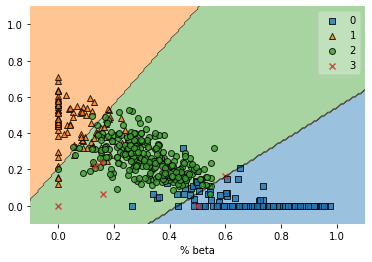

class 0: alpha, class 1: beta, class 2: alpha + beta, class 3: None


In [30]:
classifier = CATH_classifier_training(data_stride,data_cath,classifier_type=2,print_decision_regions = True)

If the classifier is the SVM with a radial basis function kernel then the decision regions are:

/usr/local/lib/python3.7/site-packages/mlxtend/plotting/decision_regions.py:249: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


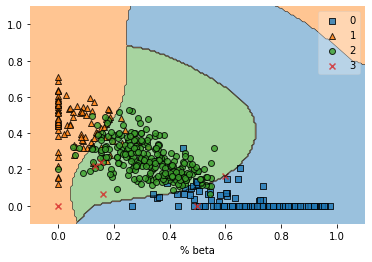

class 0: alpha, class 1: beta, class 2: alpha + beta, class 3: None


In [31]:
classifier = CATH_classifier_training(data_stride,data_cath,classifier_type=0,print_decision_regions = True)

#### Main functions  <a name="Main_functions"></a>
Using all the previously defined functions, the performance of the algorithms can be computed using cross validation. The performance is measured using the accuracy ($Q_3$) and the Mathew correlation coefficient (MCC). These are computed by the functions compute_Q3 and get_MCCs. These functions take as an input the predicted classes and the true classes. get_MCCs gives 4 outputs, the first 3 are the one versus rest coefficients while the fourth is the overall MCC.

In [32]:
def compute_Q3(ss_predicted, ss_true):
    number_residues = ss_predicted.size
    number_errors = np.count_nonzero(ss_predicted - ss_true)
    return 1-(number_errors/number_residues)

def compute_MCC(confusion_matrix):
    numerator = 0
    denominator_term_1 = 0
    denominator_term_2 = 0
    size_matrix = confusion_matrix.shape[0]
    for k in range(size_matrix):
        for l in range(size_matrix):
            for m in range(size_matrix):
                numerator += confusion_matrix[k,k]*confusion_matrix[l,m] - confusion_matrix[k,l]*confusion_matrix[m,k]

    for k in range(size_matrix):
        denominator_term_1 += np.sum(confusion_matrix[k,:])*(np.sum(confusion_matrix) - np.sum(confusion_matrix[k,:]))
    denominator_term_1 = np.sqrt(denominator_term_1)

    for k in range(size_matrix):
        denominator_term_2 += np.sum(confusion_matrix[:,k])*(np.sum(confusion_matrix) - np.sum(confusion_matrix[:,k]))
    denominator_term_2 = np.sqrt(denominator_term_2)
    
    denominator = denominator_term_1*denominator_term_2
    if denominator == 0: return 0 
    else: return numerator/denominator
    
def get_MCCs(ss_predicted, ss_true):
    MCCs = np.zeros(4)
    MCC_overall = compute_MCC(compute_confusion_matrix(ss_predicted,ss_true,3))
    MCCs[3] =  MCC_overall
    for i in range(3):
        ss_true_binary = (ss_true == i).astype(int)
        ss_predicted_binary = (ss_predicted == i).astype(int)
        MCCs[i] = compute_MCC(compute_confusion_matrix(ss_predicted_binary,ss_true_binary,2))
    return MCCs

Then cross validation using the leave one out or the Kfold cross validation is done by the 2 following functions that return the Q3, MCC and CATH class predictions for each proteins in a list format.

In [76]:
def get_ss_pred_by_GOR_for_CATH_pred(df, I, use_MSA_testing = False):
    df_out = df.copy()
    for i in pd.unique(df['protein_number']):
        test_df = df.loc[df['protein_number'] == i]
        ss_predicted =  GOR_III_predict(I, test_df,use_MSA_testing = use_MSA_testing)
        df_out.loc[df_out["protein_number"] == i, "secondary_structure_index"] = ss_predicted
    return df_out

def get_ss_pred_by_NN_for_CATH_pred(df, model,x_train):
    df_out = df.copy()
    y_pred_soft = model.predict(x_train)
    y_pred = hard_decision(y_pred_soft)
    for i in pd.unique(df_out['protein_number']):
        df_out.loc[df_out["protein_number"] == i, "secondary_structure_index"] = y_pred[df_out["protein_number"] == i]
    return df_out

def GOR_III_performance(df,df_CATH,
                        use_predicted_ss_for_CATH_prediction=False,
                        cross_validation = "leave_1_out", 
                        k=10, 
                        use_MSA_testing = False,
                        CATH_classifier_type = 0,
                        verbose = True):
    
    df_simplified = df[['protein_number', 'PDB_seq_code', 'residue_name_index', 'secondary_structure_index', 'PDB_chain_code']]
    data_list = df_simplified.values.tolist()
    total_counts = GOR_III_get_total_counts(data_list)
    number_proteins = df_simplified['protein_number'].max()

    Q3_list = np.zeros(number_proteins)
    MCCs_list = np.zeros((number_proteins,4))
    CATH_predictions_performance = np.zeros((number_proteins,2)).astype(int)

    if (cross_validation == "Kfold"):
        number_rounds = k
        proteins_numbers_shuffled = np.arange(number_proteins)
        np.random.shuffle(proteins_numbers_shuffled)
        batch_size_test = number_proteins // k # The last set will be a bit bigger
    else:
        number_rounds = number_proteins

    for i in range(number_rounds):
        if cross_validation == "leave_1_out":
            df_test = df.loc[df['protein_number'] == i]
            df_train = df.loc[df['protein_number'] != i]
            test_data_list = df_simplified.loc[df_simplified['protein_number'] == i].values.tolist()
            PDB_code_test = df['PDB_code'][df['protein_number'] == i].iloc[0]
            df_CATH_training = df_CATH[df_CATH['PDB_code']!=PDB_code_test]
            df_CATH_test = df_CATH[df_CATH['PDB_code']==PDB_code_test]
        elif cross_validation == "Kfold":
            if i != k-1:
                proteins_numbers_test =  proteins_numbers_shuffled[i*batch_size_test:(i+1)*batch_size_test]
                proteins_numbers_train = np.concatenate((proteins_numbers_shuffled[:i*batch_size_test], proteins_numbers_shuffled[(i+1)*batch_size_test:]), axis=None)
            else:
                proteins_numbers_test = proteins_numbers_shuffled[i*batch_size_test:]
                proteins_numbers_train = proteins_numbers_shuffled[:i*batch_size_test]
            
            df_test = df.loc[df['protein_number'].isin(proteins_numbers_test)]
            df_train = df.loc[df['protein_number'].isin(proteins_numbers_train)]
            test_data_list = df_simplified[df_simplified['protein_number'].isin(proteins_numbers_test)].values.tolist()
            PDB_codes_test = pd.unique(df_test['PDB_code'])
            PDB_codes_train = pd.unique(df_train['PDB_code'])
            df_CATH_training = df_CATH[df_CATH['PDB_code'].isin(PDB_codes_train)]
            df_CATH_test = df_CATH[df_CATH['PDB_code'].isin(PDB_codes_test)]
        
        I = GOR_III_get_I_remove_protein(test_data_list, total_counts)
        ss_predicted =  GOR_III_predict(I, df_test,use_MSA_testing = use_MSA_testing)
        
        if use_predicted_ss_for_CATH_prediction:
            df_ss_pred_for_CATH_pred = get_ss_pred_by_GOR_for_CATH_pred(df_train, I,use_MSA_testing)
        else:
            df_ss_pred_for_CATH_pred =  df_train
            
        CATH_classifier = CATH_classifier_training(df_ss_pred_for_CATH_pred,df_CATH_training, classifier_type = CATH_classifier_type)
        
        if cross_validation == "leave_1_out":
            ss_percentage = np.expand_dims(compute_percentage_ss(ss_predicted)[:2],0)
        else:
            ss_percentage = np.zeros((len(proteins_numbers_test),2))
            for j,protein_number in enumerate(proteins_numbers_test):
                ss = ss_predicted[df_test['protein_number'] == protein_number]
                ss_true =  df_test['secondary_structure_index'][df_test['protein_number'] == protein_number].values
                Q3_list[protein_number] = compute_Q3(ss,ss_true)
                MCCs_list[protein_number,:] = get_MCCs(ss,ss_true)
                ss_percentage[j,:] = compute_percentage_ss(ss)[:2]

        CATH_prediction = CATH_classifier.predict(ss_percentage) 

        if cross_validation == "leave_1_out":
            MCCs_list[i,:] = get_MCCs(ss_predicted,df_test['secondary_structure_index'][df_test['protein_number'] == i].values)
            Q3_list[i] = compute_Q3(ss_predicted, df_test['secondary_structure_index'][df_test['protein_number'] == i].values)
            CATH_class = df_CATH_test['protein_family_index'].iloc[0]
            CATH_predictions_performance[i,:] = np.array([CATH_class, CATH_prediction[0]])
            if verbose:
                ss_conversion = ["H","E","C"]
                ss_predicted_string = ""
                for ss in ss_predicted: ss_predicted_string+= ss_conversion[ss]
                print(PDB_code_test,ss_predicted_string , round(Q3_list[i],3), round(MCCs_list[i,3],3), list_protein_families[CATH_predictions_performance[i,1]])
        else:
            for j,protein_number in enumerate(proteins_numbers_test):
                PDB_code = df_test['PDB_code'][df_test['protein_number'] == protein_number].iloc[0]
                CATH_predictions_performance[protein_number,0] = df_CATH_test['protein_family_index'][df_CATH_test["PDB_code"] == PDB_code].iloc[0]
                CATH_predictions_performance[protein_number,1] = CATH_prediction[j]

    return Q3_list,MCCs_list,CATH_predictions_performance


def NN_performance(df,df_CATH,
                   use_predicted_ss_for_CATH_prediction=False,
                   cross_validation = "leave_1_out", 
                   k=10,
                   use_MSA_training = False, 
                   use_MSA_testing = False, 
                   MSA_df = None,
                   CATH_classifier_type = 0):
    
    df_simplified = df[['protein_number', 'PDB_seq_code', 'residue_name_index', 'secondary_structure_index','PDB_code', 'PDB_chain_code']]
    data_list = df_simplified.values
    
    if use_MSA_training or use_MSA_testing: 
        x_MSA,y_MSA = NN_change_format_data_for_input_MSA(data_list,MSA_df)  #Actually y_MSA is the same as y  
    x,y = NN_change_format_data_for_input(data_list)
    number_proteins = df_simplified['protein_number'].max()
    Q3_list = np.zeros(number_proteins)
    MCCs_list = np.zeros((number_proteins,4))
    CATH_predictions_performance = np.zeros((number_proteins,2)).astype(int)

    if (cross_validation == "Kfold"):
        proteins_numbers_shuffled = np.arange(number_proteins)
        np.random.shuffle(proteins_numbers_shuffled)
        batch_size_test = number_proteins // k # The last set will be a bit bigger
        number_rounds = k
    else:
        number_rounds = number_proteins

    for i in range(number_rounds):
        if cross_validation == "leave_1_out":
            train_indexes = np.where(data_list[:,0] != i)[0]
            test_indexes = np.where(data_list[:,0] == i)[0]
            
            df_train = df.loc[df['protein_number'] != i]
            df_test = df.loc[df['protein_number'] == i]
            PDB_codes_test = pd.unique(df_test['PDB_code'])
            PDB_codes_train = pd.unique(df_train['PDB_code'])
            df_CATH_training = df_CATH[df_CATH['PDB_code'].isin(PDB_codes_train)]
            df_CATH_test = df_CATH[df_CATH['PDB_code'].isin(PDB_codes_test)]
        else:
            if i != k-1:
                proteins_numbers_test = proteins_numbers_shuffled[i*batch_size_test:(i+1)*batch_size_test]
                proteins_numbers_train = np.concatenate((proteins_numbers_shuffled[:i*batch_size_test], proteins_numbers_shuffled[(i+1)*batch_size_test:]), axis=None)
            else:
                proteins_numbers_test = proteins_numbers_shuffled[i*batch_size_test:]
                proteins_numbers_train = proteins_numbers_shuffled[:i*batch_size_test]
            
            train_indexes = np.where(np.isin(data_list[:,0], proteins_numbers_train))[0]
            test_indexes = np.where(np.isin(data_list[:,0], proteins_numbers_test))[0]

            df_test = df.loc[df['protein_number'].isin(proteins_numbers_test)]
            df_train = df.loc[df['protein_number'].isin(proteins_numbers_train)]
            PDB_codes_test = pd.unique(df_test['PDB_code'])
            PDB_codes_train = pd.unique(df_train['PDB_code'])
            df_CATH_training = df_CATH[df_CATH['PDB_code'].isin(PDB_codes_train)]
            df_CATH_test = df_CATH[df_CATH['PDB_code'].isin(PDB_codes_test)]

        if use_MSA_training:
            x_train = x_MSA[train_indexes,:,:]
        else:
            x_train = x[train_indexes,:,:]

        y_train = y[train_indexes,:]
        model = NN_training(x_train,y_train)

        if use_MSA_training:
            x_test = x_MSA[test_indexes,:,:]
        else:
            x_test = x[test_indexes,:,:]

        y_test = y[test_indexes,:]
        prediction = model.predict(x_test)
        hard_prediction = hard_decision(prediction)

        if use_predicted_ss_for_CATH_prediction:
            df_ss_pred_for_CATH_pred = get_ss_pred_by_NN_for_CATH_pred(df_train, model,x_train)
        else:
            df_ss_pred_for_CATH_pred =  df_train

        CATH_classifier = CATH_classifier_training(df_ss_pred_for_CATH_pred,df_CATH_training, classifier_type = CATH_classifier_type)

        if cross_validation == "leave_1_out":
            ss_percentage = np.expand_dims(compute_percentage_ss(hard_prediction)[:2],0)

            y_test_not_1_hot = np.argmax(y_test, axis=1)
            MCCs_list[i,:] = get_MCCs(hard_prediction,y_test_not_1_hot)
            Q3_list[i] = compute_Q3(hard_prediction,y_test_not_1_hot)
        else:
            ss_percentage = np.zeros((len(proteins_numbers_test),2))
            for j,protein_number in enumerate(proteins_numbers_test):
                ss = hard_prediction[df_test['protein_number'] == protein_number]
                ss_true =  df_test['secondary_structure_index'][df_test['protein_number'] == protein_number].values
                ss_percentage[j,:] = compute_percentage_ss(ss)[:2]

                Q3_list[protein_number] = compute_Q3(ss,ss_true)
                MCCs_list[protein_number,:] = get_MCCs(ss,ss_true)


        CATH_prediction = CATH_classifier.predict(ss_percentage) 

        if cross_validation == "leave_1_out":
            CATH_class = df_CATH_test['protein_family_index'].iloc[0]
            CATH_predictions_performance[i,:] = np.array([CATH_class, CATH_prediction[0]])
            if verbose:
                ss_conversion = ["H","E","C"]
                ss_predicted_string = ""
                for ss in hard_prediction: ss_predicted_string+= ss_conversion[ss]
                print(PDB_codes_test,ss_predicted_string , round(Q3_list[i],3), round(MCCs_list[i,3],3), list_protein_families[CATH_predictions_performance[i,1]])

        else:
           for j,protein_number in enumerate(proteins_numbers_test):
                PDB_code = df_test['PDB_code'][df_test['protein_number'] == protein_number].iloc[0]
                CATH_predictions_performance[protein_number,0] = df_CATH_test['protein_family_index'][df_CATH_test["PDB_code"] == PDB_code].iloc[0]
                CATH_predictions_performance[protein_number,1] = CATH_prediction[j]
    return Q3_list,MCCs_list,CATH_predictions_performance

Running the leave one out cross validation on GOR III without MSA information while using experimental data to train the CATH classifier (excluding the data from the test protein) takes about 5min but running the leave one out cross validation on the Neural network with MSA information while using predicted secondary structure data to train the CATH classifier takes about 1 or 2 hours. If verbose is set to True, it prints the results under the required format from the assignment.

In [36]:
Q3_list,MCCs_list,CATH_predictions_performance = GOR_III_performance(data_stride,data_cath,verbose=True)

1w0n HHHHEHHEHECEHEECEECECCCCEEEEHCCCCCHCCHCHEECEECEEEEEECCCCCCHEEEEEEEEEEEEEEEEECCCECCECCEECHHHHHHCHHHEEEEECCCCCEHCHCHHHEHEC 0.533 0.249 Alpha/beta
2gpi CCCCCEECHHEECHHHEHHHHHHHHHCCCHEECCHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHHHHHHHCHCHCHHECEEEEHE 0.562 0.361 Alpha
1vbw EECCCCCCCHECCEHCHHHHHHHHHCCCHCHEEEEEEECCCCCCCECCECEEEEEHECCCECCCCCCE 0.691 0.496 Alpha/beta
2odk ECEHHCHHCCHHHHHHHCHCCCCCEHEHHHCCCHEEEEECHHHHHHHHHH 0.62 0.388 Alpha/beta
2zxy CCHHEEEECCCCCCCEEEECEEHCHCHHHHHHHHHHCCHHHHHHHHCCCHCHHCHCHHHHHCHCCEHHHHCCHHHHHHHHHHHEHH 0.651 0.42 Alpha
2pr7 HCEEEEEEEEEECCCCHEHHHHHHHHHHHHCCCCEEEEEECCCCCCECEECHEHEHCCCHHEEEEEECCCCCCHHHHHHHHHHHHHCCCCCHEECCHEHCCHEHHHECEEEEEHHHCHECEHEEEEEECCCCCEH 0.607 0.43 Alpha/beta
2pyq CCCCHHHHHHHHHHHCHCECCCCHHHHEHCHCHCCCCEECCCHEEECCCCEEEHHHHHHHHHEHCCCCECHCCEHEEEEEECCHCCCHCCCEEEEHEEEHCCCCECEE 0.583 0.382 Alpha/beta
1jy2 CCECCCCCCCCCCCCCCCCHCECEHEHECCHHHCHHHHCHHHC 0.605 0.416 Alpha/beta
1j3a EHHEHCCHCHHHEHHHHHHHHHCCCCEEEEEECCHHHCECCCEEEEECHCHCCCCCCCHHHHHHHHEECCCCECHCH

KeyboardInterrupt: 

The sequences of the 6 test proteins and their secondary structures are stored in the files test_prot.fasta and test_prot_ss.fasta int the fasta_files folder. Their predicted secondary structure and CATH class is computed by running the code below.

In [77]:
#Function that reads the test sequences

ss_list = ['H','E','C']
def get_test_sequences(fasta_file, ss =False):
    f = open(fasta_file, "r")
    fl = f.readlines()
    f.close()
    sequences = []
    sequences_name = []
    prot_number = 0
    for line in fl:
        if line[0] == ">":
            sequences_name.append(line[1:-1])
            if (prot_number!=0): sequences.append(my_seq)
            my_seq = []
            prot_number+=1
        else:
            for i in range(len(line)-1):
                if ss: my_seq.append(ss_list.index(line[i]))
                else:
                    if line[i] in list_amino_acids_1_letter: my_seq.append(list_amino_acids_1_letter.index(line[i]))
                    else: my_seq.append(len(list_amino_acids_1_letter))    
    sequences.append(my_seq)
    return sequences_name,sequences



#Train the NN on STRIDE data set
df_simplified = data_stride[['protein_number', 
                    'PDB_seq_code', 
                    'residue_name_index', 
                    'secondary_structure_index',
                    'PDB_code', 
                    'PDB_chain_code']]
data_list = df_simplified.values
x_train,y_train=  NN_change_format_data_for_input(data_list)
model = NN_training(x_train,y_train)

#Train the CATH family classifier
CATH_classifier = CATH_classifier_training(data_stride, data_cath)

#Load the test sequences and format them for the NN
sequences_names,sequences = get_test_sequences("../fasta_files/test_prot.fasta", ss=False)
sequences_names,y_test = get_test_sequences("../fasta_files/test_prot_ss.fasta", ss=True)
x_test = []
for i in range(len(sequences)):
    tmp = np.zeros((len(sequences[i]),4), dtype = int)
    tmp[:,1] = np.arange(len(sequences[i])) 
    tmp[:,2] = sequences[i]
    x_test_i,dummy = NN_change_format_data_for_input(tmp)
    x_test.append(x_test_i)

for i in range(len(sequences)):
    
    prediction = model.predict(x_test[i])
    hard_prediction = hard_decision(prediction)
    ss_percentage = np.expand_dims(compute_percentage_ss(hard_prediction)[:2],0)
    CATH_prediction = CATH_classifier.predict(ss_percentage) 
    
    Q3 = compute_Q3(hard_prediction,np.array(y_test[i]))
    MCC = get_MCCs(hard_prediction,np.array(y_test[i]))[3]
    ss_predicted_string = ""
    for ss in hard_prediction: ss_predicted_string+= ss_list[ss]
    print(sequences_names[i],ss_predicted_string , round(Q3,3), round(MCC,3), list_protein_families[int(CATH_prediction[0])])
    print()


1arl CCCCCCCCEEHECCHHHHHHHHHHHHHHCCHHHHHHHHCCCCCCCCEEEEEECCCCCCCCEEEEEHCCCCHHEEEHHHCEEEHHHCCCCCCCCCCCHEHHHCHHHHEEEECCCCCCEEEHHHHHHHHECCCCCCCCEEEECCCCCCCCHCCCCCCCCCCCCCCCHCCECCCCCHEEEEEEEEHCCCCCCHEEEEHHCHHHEEECCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCCEEEEEEEECCCCCCEEEHCCCCEEEEEEEEHCCCCCCEECCCCCCCCCHHHCHHHEEEEHEEECCC 0.593 0.373 Alpha/beta

1ava CCCCCCCCCCCHCHHHHHHHHHEHHCCCCCCCCEECCCCCCCCCEEECCCCCCCCCCCCEEECCCCCCCCCCEEEECHCCCHHHHHHEECHHCCHHHHHHHHHHCCEEEEECCCCCCCCCCCHHHEEEHHHCCCHHHHHEHHCCCCCCHCHHEHECHCCCCEEECCCCCCEEEEEECCCCC 0.514 0.223 Alpha/beta

1avm CCEECCCCCCCCCCCCCCHCHCHHHHHCCCCHCEHHHCHCHHHHHHHHHHCHHCHHHHHHHHHHHHHHHCCCCCCEEEEECCCCCCCCCCCCCHHHCHHHHHHHCCHHHHHHHHHHHHHCCCCCCCEEEEECCCCCCEHHEHEHCCCCCCCCCCCCHHHHHHHHHHHHHHHECCCCCEEEEEEEEECCCHHHHHHHHHHCC 0.687 0.484 Alpha/beta

1hge CCCCEHEEEHCCCCCCEECCCEEEECCCCCCCCCHHHHHHHHHHHHHHHHCHHHEHHHHCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCEECHHHHHHHHHHHHHHHHHHHHHHHCCCCEEEEECCCHCCEHEHCCCCCCCCHHHHHHHHHHHEECC 0.651 0.398 Alpha

1hmo CCCCCCCCCCCCCCCE

## Results and Discussion<a name="Results"></a>
The performance of the algorithms is benchmarked by performing a leave one out cross validation on the STRIDE and DSSP provided datasets and computing the accuracy ($Q_3$ score) and the MCC score <cite data-cite="7413522/X9YYKVF2"></cite>. For a binary classification problem, the MCC score is:
\begin{align}
MCC = \frac{TP\times TN - FP\times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}
\end{align}
where $TP$ is the number of true positives, $TN$ the number of true negatives, $FP$ the number of false positives and $FN$ the number of false negatives. If the denominator is 0, it is replaced by 1. For a multiclass classification problem, a one versus rest MCC score can be computed but there exits also a multiclass MCC score which is:
\begin{align}
MCC = \frac{\sum_k \sum_l \sum_m C_{kk}C_{lm}-C_{kl}C_{mk}}{\sqrt{\sum_k \left( \sum_l C_{kl}\right)\left( \sum_{k'|k'\neq k} \sum_{l'}C_{k'l'}\right)}\sqrt{\sum_k \left( \sum_l C_{lk}\right)\left( \sum_{k'|k'\neq k} \sum_{l'}C_{l'k'}\right)}}
\end{align}
where C is the confusion matrix i.e. $C_{i,j}$ is the number of item of class $j$ that are predicted as class $i$.

## GOR III <a name="GORIII_res"></a>
In the graph below the mean Q3 score for GOR III on the STRIDE dataset is compared to the mean Q3 score of a random classifier on the same data set. For each residue, the random classifier samples a secondary structure with probability equal to the frequency of that secondary structure in the dataset.

<img src="./img/GOR_III_Q3.png" />

The mean $Q_3$ score of GOR III is $57.8$% while for the random classifier, it is $34.7$%. The same graph is plot for the overall and the one versus rest MCC scores:

<img src="./img/GOR_III_MCC.png" />

The MCC scores for the random classifiers are quite similar but for the GOR III classifier the MCC score for $\beta$ sheet versus the rest (0.25) is lower than the other MCC scores ($MCC_\alpha = 0.31 $,$MCC_{other} = 0.32 $,$MCC_{overall} = 0.31 $). This is a first indication that GOR III performs worse for $\beta$ sheets.

The next plot compares the $Q_3$ score of GOR III on the STRIDE dataset for proteins in each CATH protein family.

<img src="./img/GOR_III_Q3_per_CATH_family.png" />

The $Q_3$ mean score for proteins in the $\alpha$ CATH family ($63$%) is the highest while the $Q_3$ mean score for proteins in the $\beta$ CATH family ($54$%) is the lowest. This confirms the previous observation that GOR III performs worse on $\beta$ sheets.
    
It is interesting to note that GOR III has a very similar performance for the DSSP ($Q_3 = 0.579$) and STRIDE ($Q_3 = 0.577$) data sets as shown in the following boxplot.

<img src="./img/GOR_III_STRIDE_vs_DSSP.png" />

This is interesting since STRIDE secondary structure algorithm is an extension of the DSSP algorithm. DSSP identifies hydrogen bonds based on inter atomic distances from a 3D model experimentally found (with X-Ray, NMR or other). STRIDE adds dihedral angle potentials to the model to determine the secondary structure. That shows that GOR III has an almost identical performance on the 2 secondary structure definitions.  

The next performed experiment was to vary the window size ($=2\times w+1$) from 0 to $21$ for GOR III. The boxplot for different values of $w$ is given below.

<img src="./img/GOR_III_Q3_w.png" />

While an increase of $w$ increases the performance of the algorithm, it saturates by $w = 4$. Since in the original GOR III, $w=8$ was used, it is very probable that $w=8$ gave the best result for their implementation. The main difference between the algorithm described in the original paper and the algorithm implemented in this assignment is the way small counts during the pmi estimation are dealt with. In the original paper, they used Bayesian statistics to decrease the impact of small counts while here a pseudo count of $0.001$ is used. Increasing the value of this pseudo count would probably increase the performance of the algorithm since it would put less weight on small counts.

In the next boxplot, the impact of using evolutionary information on the prediction step of GOR III on the $Q_3$ score is measured.

<img src="./img/GOR_III_MSA.png" />

The mean $Q_3$ score is almost identical (0.578 without evolutionary information and 0.576 with it) however the variance of the $Q_3$ score increases when using evolutionary information. This is unfortunate since a lot of time and energy was put to obtain that evolutionary information. As mentioned before the low performance of this implementation of GOR III may be due to the low value for the pseudo counts. Maybe if that value was increased, adding evolutionary information would increase the performance of GOR III. Another possible reason of the discrepancy between this result and the result reported in <cite data-cite="7413522/8PN2TYVH"></cite> is the procedure used to obtain the evolutionary information.

## Neural Network <a name="NN_res"></a>

The neural network classifier has a better performance than GOR III as shown in the following boxplot of the $Q_3$ score.

<img src="./img/GOR_III_vs_NN_Q3.png" />

The neural network achieves a mean accuracy of $Q_3 = 65$%. The neural netowrk also performs less well on $\beta$ sheets as shown on the following box plot of the one versus rest MCC scores.

<img src="./img/NN_MCC.png" />

Unfortunately adding the evolutionary information as in the PHD method in the implemented neural network worsens its performance as shown on the following boxplot.

<img src="./img/NN_MSA.png" />

Adding evolutionary information decreases the mean $Q_3$ score from $65$% to $62$%. This could be explained by two reasons. It may be caused by the parameters used to obtain the evolutionary information. Maybe changing the Evalue threshold or the maximum number of hits, would change this result. The second reason could be that the neural network does not contain enough nodes or layers to learn from the evolutionary information. In the PHD method, they use 2 neural networks that are serially concatenated. Moreover, spending time tuning hyperparameters from the neural network could maybe increase its performance when evolutionary information is used.  

## CATH family  <a name="CATH_res"></a>
The CATH family classifiers take as input the percentage of residues forming an $\alpha$ helix and $\beta$ sheet. The scatter of the proteins from the STRIDE data set is given below.

<img src="./img/scatter.png" />

Since there are only 6 proteins in the None category and since they are not in a specific region of this two dimensional space, it is expected that the classifiers will fail to predict them correctly.

The performance of the implemented CATH family classifiers on the training set when trained with the experimental data from STRIDE is close to $90$%. However the performance on the test set generated by the secondary structure algorithms is much lower. The confusion matrix of the CATH classifiers obtained with a leave one out crossvalidation of the GOR III algorithm are given below. For each round in the cross validation, the classifiers were trained with the experimentally found secondary structures from the STRIDE dataset (excluding the secondary structure of the protein that needs to be predicted). The column  of the confusion matrix corresponds to the true class while the row corresponds to the predicted class.

Confusion matrix for the SVM classifier with radial basis function kernel:

| Classes  | $\alpha$  | $\beta$  | $\alpha$ $+ \beta$  |  None |
|---|---|---|-----|---|
| $\alpha$  | 48  |  0 | 6  | 0  |
| $\beta$  |  0 | 15  | 8  | 0  |
| $\alpha + \beta$  | 80  | 84  | 245  | 6  |
| None | 0  | 0  | 0  | 0  |

Confusion matrix for the SVM classifier with linear kernel:

| Classes  | $\alpha$  | $\beta$  | $\alpha$ $+ \beta$  |  None |
|---|---|---|-----|---|
| $\alpha$  | 44  |  0 | 4  | 0  |
| $\beta$  |  0 | 12  | 87  | 0  |
| $\alpha + \beta$  | 84  | 87  | 248  | 6  |
| None | 0  | 0  | 0  | 0  |

Confusion matrix for the logistic regression classifier:

| Classes  | $\alpha$  | $\beta$  | $\alpha$ $+ \beta$  |  None |
|---|---|---|-----|---|
| $\alpha$  | 46  |  0 | 6  | 0  |
| $\beta$  |  0 | 8  | 6  | 0  |
| $\alpha + \beta$  | 82  | 91  | 247  | 6  |
| None | 0  | 0  | 0  | 0  |

They are very similar for each classifier and their accuracy is between 61% and 63%. As expected the proteins from the None class were wrongly predicted. The classifiers tend to predict most proteins class as $\alpha + \beta$, this could be explained by two main reasons. Firstly the training set is unbalanced and this has been reported in the literature to affect the performance of the one versus rest (OvR) multiclass classifiers. Another possible reason is the fact that the classifiers are trained with high quality secondary structures from STRIDE while the proteins classes are predicted from lower quality secondary structure predictions from GOR III. The prediction of $\beta$ proteins is very innacurate. 99 proteins in the data set are in the $\beta$ family. With the SVM classifier with radial basis function kernel 80 of them were predicted to be in the $\alpha+\beta$ family while only 15 were correctly predicted. This is the class whith lowest performance which correlates with GOR III and the neural network performing worse on $\beta$ sheets.

Training the classifiers with secondary structures predicted by GOR III can be done by setting the parameter use_predicted_ss_for_CATH_prediction = True in the GOR_II_performance function. During the leave one out procedure, the secondary structure of each protein in the training set is predicted with the GOR III algorithm trained on that same training set. This means that at each round of the cross validation, the secondary structure of all the proteins in the training set need to be predicted. Using this procedure, the confusion matrix for the SVM classifier with radial basis function kernel is:

| Classes  | $\alpha$  | $\beta$  | $\alpha$ $+ \beta$  |  None |
|---|---|---|-----|---|
| $\alpha$  | 38  |  15 | 1  | 0  |
| $\beta$  |  6 | 47  | 61  | 2  |
| $\alpha + \beta$  | 84  | 37  | 197  | 4  |
| None | 0  | 0  | 0  | 0  |

It can be observed that in spite of having a lower accuracy ($57$%), the bias of the classifier is decreased. Out of 99 $\beta$ proteins, 47 were correctly predicted. While in theory, to using another leave one out cross validation procedure to generate the training set of the CATH classifier at each round of the leave one out crossvalidation of the main algorithm, would increase the performance of the the CATH classfier, this is too computationally expensive. 

It would be interesting to design a protein family classifier that takes as input the output probabilities of the neural network or GOR III instead of their hard predictions.

## Conclusion <a name="Conclusion"></a>
In this assignment, GOR III and a secondary structure classifier based on a neural network were implemented. The neural network classifier outperformed GOR III but both had a lower performance on $\beta$ sheets than on other secondary structures.

In the given implementation, adding evolutionary information does not affect the performance of GOR III and worsens the performance of the neural network. This could be explained by a low pseudo count used for GOR III and a non optimal choice of architecture and hyper parameters for the neural network. Another reason could be a non optimal set of parameters used to obtain that evolutionary information.

Different classifiers were trained to predict the CATH family of a protein given its secondary structure prediction from GOR III or the neural network. Support vector machines as well as a logistic regression were implemented. While they had a similar performance, they all had a strong bias towards the $\alpha + \beta$ class. Training the classifiers on predicted secondary structures instead of on true secondary structures decreased the bias at the expense of a slightly lower accuracy.

It would be interesting to generate a consensus classifier that combines the predictions from GOR III and the neural Network to increase their individual performances.

## Bibliography
<div class="cite2c-biblio"></div>